# Code to gather data from full AGN catalogue.

We want to obtain data from several surveys and catalogs in order to  
manipulate them and try to obtain meaningful correlations.

First, we import the packages to be used

To get the first line working, you need  
to run the following lines:

```bash
 conda install nodejs
 pip install ipympl
 pip install --upgrade jupyterlab
 jupyter labextension install @jupyter-widgets/jupyterlab-manager
 jupyter labextension install jupyter-matplotlib
 jupyter nbextension enable --py widgetsnbextension
 ```

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
# import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
# import matplotlib.patheffects as path_effects
# from matplotlib.ticker import FormatStrFormatter
# from matplotlib.patches import Polygon
from astropy.io import fits
from astropy.table import Table
from astropy.table import Column
from astropy.table import MaskedColumn
from astropy.table import hstack
from astropy.table import vstack
from astropy.table import join
from astropy.wcs import WCS
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM
from astropy.coordinates import SkyCoord
from astroquery.simbad import Simbad
from astroquery.ned import Ned
from urllib.request import urlopen
import xmltodict
import getpass
import progressbar
import pandas as pd
import re

Define the spectral index $\alpha$ from different sources  
to be used in the luminosity calculations (K-correction)

In [2]:
alpha_first = 0.5  # From FIRST data (Bornancini+2010)
alpha_RG    = 1.0  # For radio galaxies (Verkhodanov & Khabibullina, 2010)
alpha_alex  = 0.8  # Star-forming galaxies (Alexander+2003)
alpha_smol  = 0.7  # Mean value from VLA-COSMOS 3GHz sample (Smolčić et al. 2017)
alpha_butl  = 0.75  # From Butler et al., 2018

In [3]:
gamma_alex  = 2.0  # From Alexander+2003 (photon index for X-Rays)

Choose one of the spectral indexes

In [4]:
alpha_used  = alpha_butl

In [5]:
gamma_used  = gamma_alex

We define the cosmological properties to calculate luminosity distances and other quantities.

In [6]:
cosmo       = FlatLambdaCDM(H0=70, Om0=0.3)

In [7]:
def lum_from_flux(flux, redshift):  # Flux in mJy
    lum_distance = cosmo.luminosity_distance(redshift).to(u.m).value  # in m
    luminosity   = 4 * np.pi * lum_distance**2 * flux * 1e-3  * 1e-26 * (1 + redshift)**(alpha_used - 1)  # in W/Hz
    return luminosity

In [8]:
pe1            = [mpe.Stroke(linewidth=3, foreground='black'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]
pe2            = [mpe.Stroke(linewidth=3.0, foreground='white'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]

---

### Reading data

Next step, reading our data.  
We have created a catalogue file (.fits) with Topcat containing  
data from several catalogues

In [9]:
machine  = getpass.getuser()
# cat_path = '/home/' + machine + '/Documentos/Data/'
cat_path = '../clean_catalogs/'  # relative path to the same directory

~~Read data from FIRST+MILLIQUAS catalogs cross-matched.~~  
Read data from FIRST (from its version `14dec17`) crossmatched with  
SDSS Quasar Catalog (`SDSSDR14Q_v4_4`).

**FIRST + (SDSSQ)**   

Redshift values have been retrieved from the column `pipeline_redshift` in SDSS DR12  
The procedure to obtain these values is explained in **Bolton+2012**  

We also select sources with have explicitely data in both SDSS Quasar Catalog and  
in the FIRST survey (`first_match_flag = 1`).  

In order to get only the best redshift values, we select sources with  
`pipeline_redshift_flag = 0`.

Thus, we can use 11238 objects from the catalog.

In [10]:
# full_init_table = Table.read(cat_path + 'COMOS_SDSSQ_Stripe82_Ross_Perger_merged_Nov_01.fits', format='fits')
full_init_table = Table.read(cat_path + 'COMOS_SDSSQ_Stripe82_Ross_Perger_20cm_z_5_Nov_02.fits', format='fits')

In [11]:
# full_init_table.colnames

In [12]:
full_init_coords = SkyCoord(ra=full_init_table['RA'], dec=full_init_table['DEC'], unit=u.deg)

Remove elements without coordinates.

In [13]:
filt_coords      = np.isnan(full_init_coords.ra)

In [14]:
full_init_table  = full_init_table[~filt_coords]

In [15]:
full_init_coords = full_init_coords[~filt_coords]

Plot coordinates in the Sky.

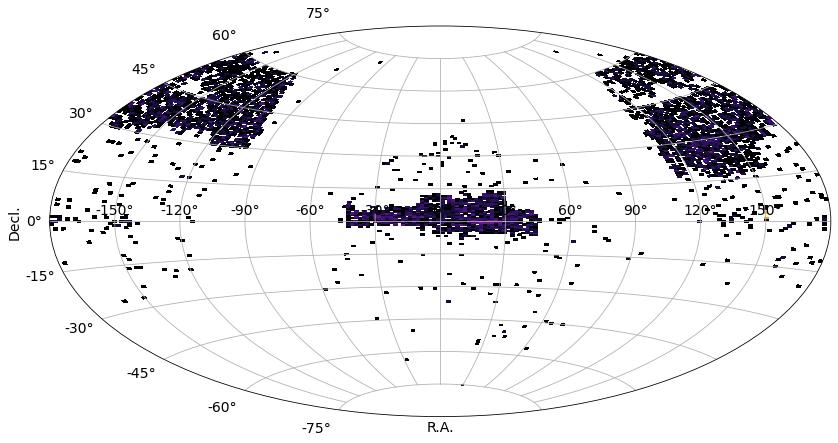

In [16]:
fig      = plt.figure(figsize=(14,9))
ax1      = fig.add_subplot(111, projection='aitoff')

# ra       = full_init_coords[:10000].ra.wrap_at(180*u.degree).rad
# dec      = full_init_coords[:10000].dec.rad
ra       = full_init_coords.ra.wrap_at(180*u.degree).rad
dec      = full_init_coords.dec.rad


# ax1.plot(ra, dec, marker='o', ls='None', markersize=2, alpha=0.5, color='grey', mec='k')
# ax1.hexbin(ra, dec, cmap=plt.cm.Purples, gridsize=500, mincnt=1, bins='log')
Z, _, __ = np.histogram2d(ra, dec, bins=200)
ax1.pcolormesh(_, __, Z.T, cmap=plt.cm.magma, norm=mcolors.LogNorm(vmax=Z.max()))
ax1.grid(True)
ax1.set_xlabel('R.A.', size=14)
ax1.set_ylabel('Decl.', size=14)
ax1.tick_params(labelsize=14)
# aaa = [val.get_text() for val in ax1.get_xticklabels()]
# ax1.set_xticklabels(aaa, path_effects=pe2)
plt.savefig('../plots/sky_distribution_cat_Nov_08.pdf')

In [17]:
sample_size = np.shape(full_init_table)[0]

Convert units, in general, to $\mathrm{mJy}$ or $\mathrm{Jy}$

In [18]:
# full_init_table.info

In [19]:
full_init_table['FUV'].unit = u.nanomaggy
full_init_table['FUV_IVAR'].unit = u.nanomaggy
full_init_table['NUV'].unit = u.nanomaggy
full_init_table['NUV_IVAR'].unit = u.nanomaggy

In [20]:
zero_point_star_equiv  = u.zero_point_flux(3631.1 * u.Jy)  # zero point to Jansky
# full_init_table['FUV'] = u.Magnitude(full_init_table['FUV'].to(u.AB, zero_point_star_equiv))
full_init_table['FUV'] = full_init_table['FUV'].to(u.AB, zero_point_star_equiv)
full_init_table['FUV_IVAR'] = full_init_table['FUV_IVAR'].to(u.AB, zero_point_star_equiv)
full_init_table['NUV'] = full_init_table['NUV'].to(u.AB, zero_point_star_equiv)
full_init_table['NUV_IVAR'] = full_init_table['NUV_IVAR'].to(u.AB, zero_point_star_equiv)

In [21]:
full_init_table['FUV'] = full_init_table['FUV'].to(u.Jy)
full_init_table['FUV_IVAR'] = full_init_table['FUV_IVAR'].to(u.Jy)
full_init_table['NUV'] = full_init_table['NUV'].to(u.Jy)
full_init_table['NUV_IVAR'] = full_init_table['NUV_IVAR'].to(u.Jy)

In [22]:
for col in ['FUV', 'FUV_IVAR', 'NUV', 'NUV_IVAR']:
    filt_neg = np.array(full_init_table[col] <= 0)
    full_init_table[col][filt_neg] = np.nan

In [23]:
bands_freqs = {'2RXS_SRC_FLUX': 3.02e+17 * u.Hz, '2RXS_SRC_FLUX_ERR': 3.02e+17 * u.Hz,\
               'XMM_TOTAL_FLUX_ERR': 1.51e+18 * u.Hz, 'Soft_flux': 6.05e+17 * u.Hz, 'Soft_flux_err': 6.05e+17 * u.Hz,\
               'Hard_flux': 1.45e+18 * u.Hz, 'Hard_flux_err': 1.45e+18 * u.Hz, 'Full_flux': 1.51e+18 * u.Hz,\
               'S5-10': 1.81e+18 * u.Hz, 'e_S5-10': 1.81e+18 * u.Hz, 'F0.5-7': 9.07e+17 * u.Hz, 'e_F0.5-7': 9.07e+17 * u.Hz}

In [24]:
# (full_init_table[column] / bands_freqs[column]).unit

In [25]:
for column in full_init_table.columns:
    col_unit = full_init_table[column].unit
    if col_unit == u.mag:
        full_init_table[column].unit = u.ABmag
        full_init_table[column] = full_init_table[column].to(u.Jy)
    elif col_unit == (u.W / u.Hz / u.m**2):
        full_init_table[column] = full_init_table[column].to(u.Jy)
    elif col_unit in [(u.erg / u.cm**2 /u.s), (1e-17 * u.W / u.m**2)]:  # Need frequency
        full_init_table[column] = full_init_table[column] / bands_freqs[column]
        full_init_table[column].unit /= u.Hz
        full_init_table[column] = full_init_table[column].to(u.Jy)

Then, we can query the database to obtain the desired data.  In this point,  
we also add more columns to be queried.

In [26]:
query_simbad_flag               = False
save_simbad_flag                = False
load_simbad_flag                = True
create_simbad_inayoshi_flag     = False
read_simbad_inayoshi_flag       = False
query_ned_names_flag            = False
save_ned_names_flag             = False
load_ned_names_flag             = False
query_ned_zs_flag               = False
save_ned_zs_flag                = False
load_ned_zs_flag                = False
query_ned_phot_flag             = False
save_phot_bands_list_flag       = False
load_phot_bands_list_flag       = False
order_ned_phot_flag             = False
save_ned_photo_flag             = False
load_ned_photo_flag             = False
group_bands_flag                = False
save_group_bands_flag           = False
load_group_bands_flag           = False
merge_tables_flag               = False
save_merged_tabs_flag           = False

In [27]:
if query_simbad_flag:
    customSimbad   = Simbad()
    initial_fields = customSimbad.get_votable_fields()
    
    customSimbad.add_votable_fields('otypes')
    if 'coordinates' in initial_fields:
        customSimbad.remove_votable_fields('coordinates')
        customSimbad.add_votable_fields('ra(d)', 'dec(d)')
    if 'z_value' not in initial_fields:
        customSimbad.add_votable_fields('z_value')
    for band in ['B','V','R','I','J','K']:  # Fluxes are in units of magnitude
        if f'fluxdata({band})' not in initial_fields:
            customSimbad.add_votable_fields(f'flux({band})', f'flux_error({band})')

To standardize results, queries  
will only be based on coordinates (not names).

Query objects in separate bunches to avoid overload.

In [28]:
# 'QSO' in str(aaa['OTYPES'].data.data[0], "utf-8")

In [29]:
if query_simbad_flag:
    result_table_simbad_tmp = Table()

In [30]:
if query_simbad_flag:
    query_error = 0
    final_error = 0

In [31]:
# import warnings
# warnings.filterwarnings('ignore')

In [32]:
sub_size = 2500
if query_simbad_flag:
    subsample_limits = np.arange(start=sub_size, stop=sample_size, step=sub_size, dtype=int)
    for limit in subsample_limits:
        max_lim = limit
        if limit == subsample_limits[-1]: max_lim = sample_size
        with progressbar.ProgressBar(min_value=(limit - sub_size), max_value=max_lim) as bar:
            for index, coord in enumerate(full_init_coords[(limit - sub_size):max_lim]):
                temp_table      = Table()
                try:
                    temp_table      = customSimbad.query_region(coord, radius=2.0*u.arcsec)
                    if len(temp_table) == 0:
                        temp_table      = Table(names=('RA_d', 'DEC_d'), dtype=(result_table_simbad_tmp['RA_d'].info.dtype,\
                                                                                result_table_simbad_tmp['DEC_d'].info.dtype))
                        temp_table.add_row((coord.ra.deg, coord.dec.deg))
                    temp_table.meta['description'] = 'Simbad_q'
                except:
                    temp_table      = Table(names=('RA_d', 'DEC_d'), dtype=(result_table_simbad_tmp['RA_d'].info.dtype,\
                                                                            result_table_simbad_tmp['DEC_d'].info.dtype))
                    temp_table.add_row((coord.ra.deg, coord.dec.deg))
                    temp_table.meta['description'] = 'Simbad_q'
                    #print(f'Error with element {(index)} of the sample')
                    query_error += 1
                try:
                    if temp_table['RA_d'].unit != 'deg':
                        replacement_col     = MaskedColumn(temp_table['RA_d'].data, dtype=result_table_simbad_tmp['RA_d'].dtype,\
                                                           unit=result_table_simbad_tmp['RA_d'].unit,\
                                                           format=result_table_simbad_tmp['RA_d'].format,\
                                                           description=result_table_simbad_tmp['RA_d'].description)
                        temp_table['RA_d']  = replacement_col
                    if temp_table['DEC_d'].unit != 'deg':
                        replacement_col     = MaskedColumn(temp_table['DEC_d'].data, dtype=result_table_simbad_tmp['DEC_d'].dtype,\
                                                           unit=result_table_simbad_tmp['DEC_d'].unit,\
                                                           format=result_table_simbad_tmp['DEC_d'].format,\
                                                           description=result_table_simbad_tmp['DEC_d'].description)
                        temp_table['DEC_d']  = replacement_col
                    result_table_simbad_tmp  = vstack([result_table_simbad_tmp, temp_table[0]])
                except:
                    print(f'Error with element {(index)} of the sample')
                    temp_table      = Table(names=('RA_d', 'DEC_d'), dtype=(result_table_simbad_tmp['RA_d'].info.dtype,\
                                                                            result_table_simbad_tmp['DEC_d'].info.dtype))
                    temp_table.add_row((coord.ra.deg, coord.dec.deg))
                    temp_table.meta['description'] = 'Simbad_q'
                    result_table_simbad_tmp = vstack([result_table_simbad_tmp, temp_table[0]])
                    final_error += 1
                bar.update(limit - sub_size + index)

In [33]:
if query_simbad_flag:
    result_table_simbad_tmp.info

In [34]:
if query_simbad_flag:
    for count, column in enumerate(result_table_simbad_tmp.colnames):
        if 'float' in result_table_simbad_tmp[column].dtype.name:
            result_table_simbad_tmp[column].fill_value = np.nan
        if 'str' in result_table_simbad_tmp[column].dtype.name:
            result_table_simbad_tmp[column].fill_value = ''

In [35]:
if save_simbad_flag:
    result_table_simbad = result_table_simbad_tmp
    str_id = result_table_simbad['MAIN_ID'].astype('str')
    otypes = result_table_simbad['OTYPES'].astype('str')
    result_table_simbad.replace_column('MAIN_ID', str_id)
    result_table_simbad.replace_column('OTYPES', otypes)

In [36]:
if query_simbad_flag:
    result_table_simbad.info

In [37]:
if save_simbad_flag:
    result_table_simbad.write(cat_path + 'simbad_query_flux_20cm_z_5_nov_02.fits', format='fits',\
                               overwrite=True)

In [38]:
if load_simbad_flag:
    result_table_simbad     = Table.read(cat_path + 'simbad_query_mJy_flux_20cm_z_5_nov_05.fits', format='fits');

In [39]:
customNed             = Ned()
flds_to_rmv_phot = ['Photometry Measurement', 'Uncertainty', 'Units', 'Significance',\
                    'Published frequency', 'Frequency Mode', 'Coordinates Targeted', 'Spatial Mode',\
                    'Qualifiers', 'Comments']
flds_to_rmv_init = ['No', 'Velocity', 'Magnitude and Filter', 'References', 'Notes', 'Positions',\
                    'Redshift Points', 'Diameter Points', 'Associations']

Cone search. RA, Dec in degrees. Search radius in arcmin

Querying sources with name in `Ned`.

As before, we can do it with coordinates.  

First, we query the coordinates. If we found something,  
we use the name of the source to obtain it photometry.

In [40]:
if query_ned_names_flag:
    empty_tab_name_counter  = 0
    empty_tab_photo_counter = 0
    error_tab_name_counter  = 0
    error_tab_photo_counter = 0
    ned_tables              = {}
    ned_rows                = []
    ned_info                = {}
    ned_names               = []
    ned_zs                  = []

In [41]:
if query_ned_names_flag:
    with progressbar.ProgressBar(min_value=0, max_value=sample_size) as bar:
        for index, coord in enumerate(full_init_coords):
            ra_t   = coord.ra.deg.round(5)
            dec_t  = coord.dec.deg.round(5)
            radius = (2.0 * u.arcsec).to(u.degree).value.round(5)
            domain = 'http://ned.ipac.caltech.edu/cgi-bin/nph-objsearch'
            search_type = 'Near+Position+Search'
            xml_v  = 'xml_main'
            search_url = f'{domain}?%20search_type={search_type}&of={xml_v}&%20RA={ra_t}&DEC={dec_t}&SR={radius}'
            
            xml_file = urlopen(search_url)
            xml_data = xml_file.read()
            xml_file.close()
            dict_data = xmltodict.parse(xml_data)
            try:
                ned_name  = dict_data['VOTABLE']['RESOURCE']['TABLE']['DATA']['TABLEDATA']['TR'][0]['TD'][1]  # Could be empty if no match
                ned_ra    = dict_data['VOTABLE']['RESOURCE']['TABLE']['DATA']['TABLEDATA']['TR'][0]['TD'][2]  # R.A.
                ned_dec   = dict_data['VOTABLE']['RESOURCE']['TABLE']['DATA']['TABLEDATA']['TR'][0]['TD'][3]  # Declination
                ned_otype = dict_data['VOTABLE']['RESOURCE']['TABLE']['DATA']['TABLEDATA']['TR'][0]['TD'][4]  # obs type (G, QSO, etc.)
                ned_zval  = dict_data['VOTABLE']['RESOURCE']['TABLE']['DATA']['TABLEDATA']['TR'][0]['TD'][6]  # redshift
                ned_sep   = dict_data['VOTABLE']['RESOURCE']['TABLE']['DATA']['TABLEDATA']['TR'][0]['TD'][9]  # Separation
                
                if ned_name == None:
                    ned_name = 'No Name'
                if ned_zval == None:
                    ned_zval = full_init_table['redshift'][index]
                
                temp_row  = (ned_name, float(ned_ra), float(ned_dec), round(float(ned_zval), 4), ned_otype)
                
                ned_zs.append(round(float(ned_zval), 4))
                ned_names.append(ned_name)
                ned_rows.append(temp_row)
            except:
                try:
                    ned_name  = dict_data['VOTABLE']['RESOURCE']['TABLE']['DATA']['TABLEDATA']['TR']['TD'][1]  # Could be empty if no match
                    ned_ra    = dict_data['VOTABLE']['RESOURCE']['TABLE']['DATA']['TABLEDATA']['TR']['TD'][2]  # R.A.
                    ned_dec   = dict_data['VOTABLE']['RESOURCE']['TABLE']['DATA']['TABLEDATA']['TR']['TD'][3]  # Declination
                    ned_otype = dict_data['VOTABLE']['RESOURCE']['TABLE']['DATA']['TABLEDATA']['TR']['TD'][4]  # obs type (G, QSO, etc.)
                    ned_zval  = dict_data['VOTABLE']['RESOURCE']['TABLE']['DATA']['TABLEDATA']['TR']['TD'][6]  # redshift
                    ned_sep   = dict_data['VOTABLE']['RESOURCE']['TABLE']['DATA']['TABLEDATA']['TR']['TD'][9]  # Separation
                    
                    if ned_name == None:
                        ned_name = 'No Name'
                    if ned_zval == None:
                        ned_zval = full_init_table['redshift'][index]
                    
                    temp_row  = (str(ned_name), float(ned_ra), float(ned_dec), round(float(ned_zval), 4), ned_otype)
                    
                    ned_zs.append(round(float(ned_zval), 4))
                    ned_names.append(ned_name)
                    ned_rows.append(temp_row)
                except:
                    temp_row  = ('No Name', ra_t, dec_t, full_init_table['redshift'][index].round(4), '')
                    ned_rows.append(temp_row)
                    ned_names.append('No Name')
                    ned_zs.append(full_init_table['redshift'][index].round(4))
                    # empty_tab_name_counter += 1
                    error_tab_name_counter += 1
                    # bar.update(index)
            bar.update(index)

In [42]:
if query_ned_names_flag:
    tab_ned_names = Table(rows=ned_rows, names=['Name_ned', 'ra', 'dec', 'redshift_ned', 'object type'])
    tab_ned_names['ra'].unit = 'deg'
    tab_ned_names['dec'].unit = 'deg'

In [43]:
if save_ned_names_flag:
    tab_ned_names.write(cat_path + 'ned_names_query_flux_20cm_z_5_nov_03.fits',\
                        format='fits', overwrite=True)

In [44]:
if load_ned_names_flag:
    tab_ned_names = Table.read(cat_path + 'ned_names_query_flux_20cm_z_5_nov_03.fits', format='fits')
    tab_ned_names['Name_ned'].astype('str')
    ned_names     = tab_ned_names['Name_ned'].astype('str').data
    ned_zs        = tab_ned_names['redshift_ned'].data

In [45]:
if query_ned_zs_flag:
    ned_zs_unc = []

In [46]:
if query_ned_zs_flag:
    with progressbar.ProgressBar(min_value=0, max_value=sample_size) as bar:
        for index, (name, ned_z) in enumerate(zip(ned_names, ned_zs)):
            if name == 'No Name':
                ned_zs_unc.append(np.nan)
                bar.update(index)
                continue
            try:
                temp_z_tab = customNed.get_table(name, table='redshifts')
                ned_z_e    = float(temp_z_tab['Published Redshift Uncertainty'][0])
                if ned_z_e < 0:
                    ned_zs_unc.append(np.nan)
                elif not np.isfinite(ned_z_e):
                    ned_zs_unc.append(np.nan)
                else:
                    ned_zs_unc.append(ned_z_e)
            except:
                ned_zs_unc.append(np.nan)
            bar.update(index)

In [47]:
if query_ned_zs_flag:
    ned_zs_unc_a   = np.array(ned_zs_unc)
    ned_zs_unc_col = Column(ned_zs_unc, name='z_ned_err')

In [48]:
if query_ned_zs_flag:
    tab_ned_names.add_column(ned_zs_unc_col)

In [49]:
if save_ned_zs_flag:
    tab_ned_names.write(cat_path + 'ned_names_zs_flux_20cm_z_5_nov_04.fits', format='fits', overwrite=True)

In [50]:
if load_ned_zs_flag:
    tab_ned_names = Table.read(cat_path + 'ned_names_zs_flux_20cm_z_5_nov_04.fits', format='fits')

In [51]:
if query_ned_phot_flag:
    empty_tab_photo_counter = 0
    error_tab_photo_counter = 0
    ned_tables              = {}
    ned_freqs               = []

In [52]:
if query_ned_phot_flag:
    with progressbar.ProgressBar(min_value=0, max_value=sample_size) as bar:
        for index, name in enumerate(tab_ned_names['Name_ned']):
            try:
                if name == 'No Name':
                    # phot_table        = Table(names=('Observed Passband',), dtype=('str',), masked=True)
                    # phot_table.add_row(('No Passband',), mask=(True,))
                    first_row         = [[0], ['No Passband']]
                    phot_table        = Table(first_row, names=('No.', 'Observed Passband'), dtype=('int', 'str'), masked=True)
                    ned_tables[index] = phot_table
                    empty_tab_photo_counter += 1
                    bar.update(index)
                    continue
                phot_table            = customNed.get_table(name, table='photometry', output_table_format=3)
                pass_name  = phot_table['Observed Passband'].astype('str')
                ned_unit   = phot_table['NED Units'].astype('str')
                ned_ref    = phot_table['Refcode'].astype('str')
                ned_unc    = phot_table['NED Uncertainty'].astype('str')
                phot_table.replace_column('Observed Passband', pass_name)
                phot_table.replace_column('NED Units', ned_unit)
                phot_table.replace_column('Refcode', ned_ref)
                phot_table.replace_column('NED Uncertainty', ned_unc)
                phot_table.remove_columns(flds_to_rmv_phot)
                ned_tables[index]     = phot_table
                # Add frequencies to list
                for band, freq in zip(phot_table['Observed Passband'], phot_table['Frequency']):
                    ned_freqs.append([band, freq])
            except:
                # phot_table            = Table(names=('Observed Passband',), dtype=('str',), masked=True)
                # phot_table.add_row(('No Passband',), mask=(True,))
                first_row             = [[0], ['No Passband']]
                phot_table            = Table(first_row, names=('No.', 'Observed Passband'), dtype=('int', 'str'), masked=True)
                ned_tables[index]     = phot_table
                error_tab_photo_counter += 1
            bar.update(index)

In [53]:
if query_ned_phot_flag:
    ned_freqs_a    = np.array(ned_freqs)
    uniq, uniq_idx = np.unique(ned_freqs_a[:, 0], return_index=True)
    # unique_rows_band_names_array = ned_freqs_a[uniq_idx, :]
    unique_rows_band_names_array = ned_freqs_a[uniq_idx][ned_freqs_a[uniq_idx, 1].astype(np.float).argsort()]

Saving this list into a plain text file.

In [54]:
if save_phot_bands_list_flag:
    np.savetxt(cat_path + 'ned_band_names_freqs_nov_04.txt', unique_rows_band_names_array, fmt='%s %s', delimiter='\t')

This new file can also be loaded.

In [55]:
if load_phot_bands_list_flag:
    # unique_rows_band_names_array = np.genfromtxt(cat_path + 'ned_band_names_freqs_nov_04.txt', delimiter='\t', dtype=str)
    unique_rows_band_names_array = np.loadtxt(cat_path + 'ned_band_names_freqs_nov_04.txt', delimiter='\t', dtype=str)
    unique_band_names            = unique_rows_band_names_array[:, 0]
    unique_band_freqs            = unique_rows_band_names_array[:, 1].astype(float)

In [56]:
if order_ned_phot_flag:
    ned_phot_rows = []

In [57]:
if order_ned_phot_flag:
    with progressbar.ProgressBar(min_value=0, max_value=sample_size) as bar:
        for index, name in enumerate(tab_ned_names['Name_ned']):  # Some names will be 'No Name'
            temp_table = ned_tables[index]
            temp_table.add_index('Observed Passband')
            bands_in_tab = temp_table['Observed Passband']
            if name == 'No Name':
                temp_row = ['No Name'] + [entry for band in unique_rows_band_names_array[:, 0] for entry in [np.nan, '']]
                ned_phot_rows.append(temp_row)
                bar.update(index)
                continue
            temp_row = [name]
            for band in unique_rows_band_names_array[:, 0]:
                if band not in temp_table['Observed Passband'].data.data.tolist():
                    temp_row = temp_row + [np.nan, '']
                elif band in temp_table['Observed Passband'].data.data.tolist():
                    band_info = temp_table.loc[band]['Observed Passband']
                    if isinstance(band_info, MaskedColumn):
                        temp_row = temp_row + [temp_table.loc[band][0]['Flux Density'], temp_table.loc[band][0]['NED Uncertainty']]
                    elif isinstance(band_info, str):
                        temp_row = temp_row + [temp_table.loc[band]['Flux Density'], temp_table.loc[band]['NED Uncertainty']]
            ned_phot_rows.append(temp_row)
            bar.update(index)

In [58]:
if order_ned_phot_flag:
    phot_cols = ['Object Name'] + [prefix_ned + band for band in unique_rows_band_names_array[:, 0] for prefix_ned in ['Flux ', 'Flux Error ']]

In [59]:
if order_ned_phot_flag:
    tab_ned_phot = Table(rows=ned_phot_rows, names=phot_cols)

In [60]:
if save_ned_photo_flag:
    tab_ned_phot_df = tab_ned_phot.to_pandas()
    tab_ned_phot_df.to_hdf(cat_path + 'ned_phot_flux_20cm_z_5_nov_04.h5', 'df')
    tab_ned_phot.write(cat_path + 'ned_phot_flux_20cm_z_5_nov_04.fits', format='fits', overwrite=True) # Won't work. More than 1000 cols

In [61]:
if load_ned_photo_flag:
    tab_ned_phot_df = pd.read_hdf(cat_path + 'ned_phot_flux_20cm_z_5_nov_04.h5', key='df')

In [62]:
if load_ned_photo_flag:  # Clean values from negative fluxes and uncertainties
    for col_name in tab_ned_phot_df.columns.values[1::2]:
        filt_neg = np.array(tab_ned_phot_df[col_name] <= 0.)
        tab_ned_phot_df[col_name][filt_neg] = np.nan
    tab_ned_phot    = Table.from_pandas(tab_ned_phot_df)
    for col_name in tab_ned_phot_df.columns.values[1::2]:
        tab_ned_phot[col_name].unit = 'Jy'

Separate columns (bands) by pre-defined frequency ranges.

In [63]:
if group_bands_flag:
    band_names_flux         = np.array(['Flux ' + band_name for band_name in unique_band_names])

In [64]:
if group_bands_flag:
    limits_freqs = np.array([5.0e07, 1.0e08, 2.0e08, 5.0e08, 9.0e08, 1.3e09, 2.0e09, 7.0e09, 2.0e10, 5.0e10, 8.0e10,\
                             1.2e11, 1.9e11, 5.0e11, 2.0e12, 7.0e12, 3.2e13, 1.0e14, 1.6e14, 2.0e14, 2.6e14, 3.5e14,\
                             4.1e14, 5.0e14, 5.7e14, 6.6e14, 7.6e14, 9.0e14, 1.6e15, 2.4e15, 1.5e17, 4.0e18, 1.0e20,\
                             1.3e25])  # Hz

In [65]:
if group_bands_flag:
    limits_names = np.array(['10-38 MHz', '60-86 MHz', '111-178 MHz', '230-468 MHz', '599.1-785.8 MHz', '960-1381 MHz',\
                             '1.4-1.7 GHz', '2.2-5.5 GHz', '7.7-17 GHz', '20-44 GHz', '61-77 GHz', '81.5-105.4 GHz',\
                             '136.2-163.1 GHz', '203-375 GHz', '150-500 microns', '60-100 microns', '10-30 microns',\
                             '3-8 microns', 'K', 'H', 'J', 'I', 'i', 'r', 'V', 'g', 'B', 'u', 'NUV', 'FUV', 'Ly alpha',\
                             '0.1-12 keV', '14-195 keV', '0.1-100 GeV'])

In [66]:
if group_bands_flag:
    split_at              = unique_band_freqs.searchsorted(limits_freqs)
    groups_band_freqs     = np.split(unique_band_freqs, split_at)

In [67]:
if group_bands_flag:
    groups_band_names     = np.split(band_names_flux, split_at)

In [68]:
if group_bands_flag:
    merged_flux_catalog_df     = pd.DataFrame()

In [69]:
if group_bands_flag:
    for index, merged_name in enumerate(limits_names):
        merged_flux_catalog_df['Flux ' + merged_name] = tab_ned_phot_df[groups_band_names[index]].median(axis='columns', skipna=True)

In [70]:
if group_bands_flag:
    merged_flux_catalog_tab = Table.from_pandas(merged_flux_catalog_df)
    for col_name in merged_flux_catalog_tab.colnames:
        merged_flux_catalog_tab[col_name].fill_value = np.nan
        merged_flux_catalog_tab[col_name].unit       = 'Jy'

In [71]:
if save_group_bands_flag:
    merged_flux_catalog_tab.write(cat_path + 'merged_bands_ned_phot_flux_20cm_z_5_nov_05.fits', format='fits', overwrite=True)

In [72]:
if load_group_bands_flag:
    merged_flux_catalog_tab = Table.read(cat_path + 'merged_bands_ned_phot_flux_20cm_z_5_nov_05.fits', format='fits')

In [73]:
if merge_tables_flag:
    large_merged_tab = hstack([full_init_table, result_table_simbad, merged_flux_catalog_tab], join_type='outer')
    # large_full_tab   = hstack([full_init_table, result_table_simbad, tab_ned_phot], join_type='outer')

In [74]:
if save_merged_tabs_flag:
    large_merged_tab.write(cat_path + 'merged_bands_ned_phot_simbad_combo_flux_20cm_z_5_nov_05.fits', format='fits', overwrite=True)
    # large_full_tab.write(cat_path + 'ned_phot_simbad_combo_flux_20cm_z_5_nov_05.fits', format='fits', overwrite=True)

We load data from the VLA-COSMOS 3 GHz Large Project (**Smolčić et al. 2017**),  
which has been correlated with the sources from the VLA-COSMOS Large Project 1.4-GHz Source Catalog (**Schinnerer et al., 2007**).

Thus, we have only considered sources with observed (not estimated) $1.4$ GHz fluxes. That is, with valid  
values in the table column `flux_20cm`.

We can, also, separate sources which have an AGN X-ray counterpart
with the flag `cosm_xray_flag`

We want, also, to add $z > 6$ QSOs from the list in  
Table 3 in the review of **Inayoshi, Visbal, and Haiman, 2020**.  
Six of them have $z > 7$

Not all of them have $1.4$ GHz measurements. Others have  
measurements in different frequencies which can be translated  
into the desired frequency using, for instance, the relation  
from **Butler et al., 2018**:

$$S_{a} = S_{b} \times (\frac{\nu_{b}}{\nu_{a}})^{\alpha}$$  

We load the data from these sources. Fluxes from different frequencies than $1.4$ GHz are translated to the needed value.

Cumulate values into one array except 250GHz data.  
Millimetre luminosities will be used separately since we cannot be completely  
sure that they represent, fully, non-thermal emission (from AGN) and not dust.

To complement the dataset, we also load four $z > 5.5$ sources which  
come from the `radio` catalog in the `Heasarc` database.  
We queried the objects which have $1.4$ GHz observations that  
are within a $2.5$ arcsec of an object from the `SDSS QUASAR DR12`  
catalog. We discard the sources that are already included in the `FIRST`  
catalog, to avoid repetition.

To enlarge the size of the sample, we can also query  
the same sample, but extending the redshift range to all positive  
values. We can include, too, the exclusion of ***low quality*** redshift_values (or not).

We also include sources from the field `Stripe82` with `VLA` observations.  
The data has been obtained from **Hodge et al., 2011** (`VLASS821P4`; VLA SDSS Stripe 82 Survey 1.4-GHz Source Catalog).  
These sources have been crossmatched with the `SDSSQUASAR` catalog to obtain their redshift value.

---

### Calculate luminosities

In the future, we will calculate luminosities (in W/Hz) for different datasets  
using the expression

$$L_{1.4\mathrm{GHz}} = 4 \pi \mathrm{d}^{2}_{L} f_{1.4\mathrm{GHz}} (1 + z)^{\alpha - 1}$$

which comes from Alexander et al. 2003

We can also obtain that luminosity from the flux in $3$ GHz as

$$L_{1.4\mathrm{GHz}} = 4 \pi \mathrm{d}^{2}_{L} {(\frac{3}{1.4})}^{\alpha} f_{3\mathrm{GHz}} (1 + z)^{\alpha - 1}$$

This expression comes from Delhaize et al. 2017.

---

### Obtaining values from tables

Now, we can use the points we are interested in. Our sample from **Inayoshi et al., 2020** and the  
sources from **SDSS+FIRST** with $z>5.5$.

Another option to display the data is, instead of showing redshift in the  
horizontal axis, have the mass of the observed objects.

**Inayoshi et al., 2020** use the rest-frame UV magnitude $\mathrm{M}_{1450}$  
to calculate the mass as:

$$M = 10^{[-(\mathrm{M}_{1450} + 3.459) / 2.5]} [\mathrm{M}_{\odot}]$$

which yields, on average, the published virial mass estimates for those available.

Create formal arrays from catalogs to merge them

Arrays from `SDSS+FIRST`

In [ ]:
# #limit_z_sdss_up       = 5.5
# limit_z_sdss          = 0.0
# filter_sdss_z         = np.array(sdss_milli['Z'] > limit_z_sdss)
# xmm_freq              = 1.47e18  # Hz. Frequency for 0.2-12 keV observations

Arrays from the `COSMOS` Field

Arrays from `vlass821p4` catalog.

Arrays from the Extended **Inayoshi et al., 2020** catalog ($z > 5.5$).

Merging `SDSS+FIRST` and the extended catalog from **Inayoshi et al., 2020**

Merging `SDSS+FIRST`+**Inayoshi et al., 2020** and `VLASS821P4` data

Merging `SDSS+FIRST`+**Inayoshi et al., 2020**+`VLASS821P4` and `COSMOS` data

At this point, we also want to obtain more properties from the selected  
sources (**Inayoshi et al., 2020** + **SDSS+FIRST**). We will use `astroquery` to  
obtain information from `simbad`.

First, we obtain the names and coordinates of our sources to query them.

Create `MaskedColumns` (from `Astropy`) using the data just collected.

Then, we can query the database to obtain the desired data.  In this point,  
we also add more columns to be queried.

All sources but those from `COSMOS` catalog have meaningful (for `simbad`) names.  
Thus, separate queries will be executed. And, to standardize results, queries  
will only be based on coordinates (not names).

Query `SDSS+FIRST` (`milliquasar`) + **Inayoshi et al., 2020** + `VLASS821P4` sources.

Query for `COSMOS` sources.

Query remaining sources

We save the query to a file for future executions.

Steps to create a copy of table to save it as `fits` file.

To save running time, we can load the data from a file.

From this point, we merge the data from the query to `simbad` with the  
values from this notebook (**Inayoshi et al., 2020** and **SDSS+FIRST**).  
In order to do this, we convert the data into `astropy` columns, and then  
into `astropy` tables. They will be ready to be exported.

We write the table into a file. It can be `.fits`, `.votable`, etc.

To save running time, we can load the data from a file.

Query the objects of the table in other catalogs and services.

Querying sources with name in `Ned`.

As before, we can do it with coordinates.  

First, we query the coordinates. If we found something,  
we use the name of the source to obtain it photometry.

Save multiple data tables into one file with `pandas`

We gather the names and frequencies of all columns present in tables from `Ned`.

Unique rows (name + frequency pair) are retrieved from the previous list.

We obtain the size of this new array. It represents the number of  
unique passband configurations gathered from querying `Ned`.

Saving this list into a plain text file.

This new file can also be loaded.

Now, we create a unique table from all the individual photometry tables obtained after  
querying `Ned`. We discard measurements which have already been reported (for each individual source).

We leave uncertainty values as string to retain information about possible upper/lower limits.

This new merged column shows measurements for the following number of bands.

For data completeness, we mask entries for `MAIN_ID` and `COORD` columns.

We add a column with the redshift uncertainties from Ned.

We transform `astropy` tables into `pandas` data frames for further calculations.

In this point, we can merge both `simbad` and `Ned` tables into a larger one.

Remove duplicates in name.

We save this new table into a `HDF5`-format file for future access.

If needed, we can read the table from an external file to avoid extra running time.

And this `pandas` data frame can be transformed into an `astropy` table.